# Import Packages

In [47]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, Lambda
import torchvision.datasets as dsets
from torchsummary import summary
from torch.autograd import Variable
from tqdm import tqdm_notebook
import torchvision
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle 
%matplotlib inline

# Select Mode of Running: True(Train Model)  False(Read Pretrained Model)

In [80]:
Train_Res50_As_Teacher = True
Train_Res18_As_Student = True
Train_Res18_FromScratch = True
Train_Res50_Finetuning_As_Teacher = True
Train_Res18_Finetuning_As_Student = True

# (A) : Loading Dataset

In [49]:
train_dataset = dsets.CIFAR10(root='./data',
                              train=True,
                              transform=transforms.Compose([
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor()]),
                              target_transform=Lambda(lambda y: torch.zeros(10, 
                                        dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),value=1)),
                              download=True)

test_dataset = dsets.CIFAR10(root='./data',
                              train=False,
                              transform=transforms.Compose([
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor()]),
                              target_transform=Lambda(lambda y: torch.zeros(10, 
                                        dtype=torch.float).scatter_(dim=0, index=torch.tensor(y),value=1)),
                              download=True)

Files already downloaded and verified
Files already downloaded and verified


# (A) : Showing Some Samples From Dataset

Shape of the images: torch.Size([3, 224, 224])


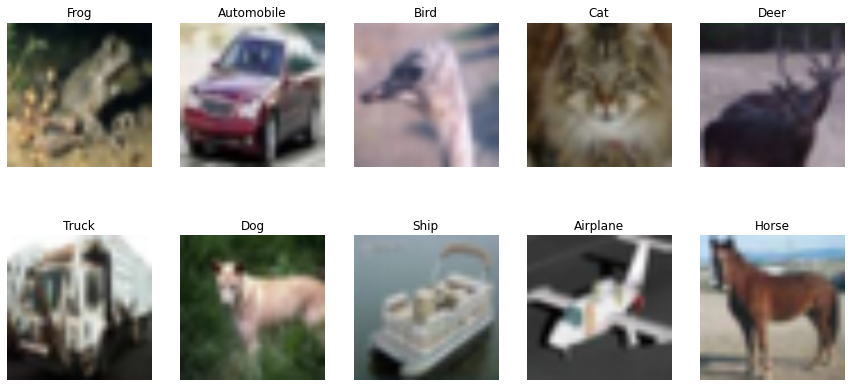

In [50]:
print(f"Shape of the images: {train_dataset[0][0].shape}")

Class_Name = { 0:"Airplane", 1:"Automobile", 2:"Bird", 3:"Cat", 4:"Deer", 5:"Dog", 6:"Frog", 7:"Horse", 8:"Ship", 9:"Truck"}
figure = plt.figure(figsize=(15, 15))
k = 0
label_list = []
while len(label_list) != 10:
    index = random.randint(0, len(train_dataset)-1)
    img, label = train_dataset[index]
    label = torch.argmax(label).item()
    if label not in label_list:
        k += 1
        label_list.append(label)
        figure.add_subplot(4, 5, k)
        plt.title(Class_Name[label])
        plt.axis("off")
        plt.imshow(transforms.ToPILImage()(img))  
    
plt.show()

# (A) : Making Dataset Iterable

In [51]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size*2, 
                                          shuffle=False)


# (A) : Define Train & Test Loop

In [9]:
def train_loop(dataloader, model, loss_fn, optimizer, log):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        
        pred = model(X.to(torch.float32).to(device))
        loss = loss_fn(pred, y.to(device))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (pred.argmax(1) == y.to(device).argmax(1)).type(torch.float).sum().item()
            
    train_loss /= num_batches
    train_acc /= size
    
    log['train_loss'].append(train_loss)
    log['train_acc'].append(train_acc)
    
    print(f"Train Result: \n Accuracy: {(100*train_acc):>0.1f}%, Avg Train loss: {train_loss:>8f} \n")

def test_loop(dataloader, model, loss_fn, log):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc, test_loss_min = 0, 0, np.Inf 
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(torch.float32).to(device))
            loss = loss_fn(pred, y.to(device))
            
            test_loss += loss.item()
            test_acc += (pred.argmax(1) == y.to(device).argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    test_acc /= size
    
    if(log!=None):
        
        log['test_loss'].append(test_loss)
        log['test_acc'].append(test_acc)
        
        if(test_loss <= min(log['test_loss'])):
            torch.save(model.state_dict(), './model/best_res50_teacher_model.pt')
            print('Model Saved')    

    print(f"Test Result: \n Accuracy: {(100*test_acc):>0.1f}%, Avg Test loss: {test_loss:>8f} \n")        

# (A) : Load Pretrained Resnet 50 Model Class

In [10]:
model_res50 = torchvision.models.resnet50(pretrained=True)

for param in model_res50.parameters():
    param.requires_grad = False

model_res50.fc = nn.Sequential(nn.Linear(2048, 10))

trainable_param_number = sum(p.numel() for p in model_res50.parameters() if p.requires_grad)

print(f"Trainable Param Number Is : {trainable_param_number:,}")

Trainable Param Number Is : 20,490


# (A) : Define Hyper Parameters & Optimizer & Loss Function (Teacher)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_res50 = model_res50.to(device)

criterion = nn.CrossEntropyLoss()

lr_sgd = 1e-3
epochs = 10
optimizer_sgd = torch.optim.SGD(model_res50.parameters(), lr=lr_sgd, momentum=0.9)

# (A) : Training Process Of Pretrained Resnet 50 As Teacher

In [12]:
if(Train_Res50_As_Teacher):
    
    log = {'train_loss':[], 'test_loss' : [], 'train_acc' : [], 'test_acc' : []}
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        model_res50.train()
        train_loop(train_loader, model_res50, criterion, optimizer_sgd, log = log)
        model_res50.eval()
        test_loop(test_loader, model_res50, criterion, log = log)
        
    print("Done!")
    
    with open('best_res50_teacher_result.pkl', 'wb') as f:
        pickle.dump(log, f)   
else:
    
    model_res50.load_state_dict(torch.load('./model/best_res50_teacher_model.pt'))  
    with open('best_res50_teacher_result.pkl', 'rb') as f:
        log = pickle.load(f)
    print('Model Loaded')
    model_res50.eval()
    test_loop(test_loader, model_res50, criterion, log = None)

Epoch 1
-------------------------------
Train Result: 
 Accuracy: 72.6%, Avg Train loss: 0.880811 

Model Saved
Test Result: 
 Accuracy: 78.5%, Avg Test loss: 0.647739 

Epoch 2
-------------------------------
Train Result: 
 Accuracy: 78.3%, Avg Train loss: 0.651449 

Model Saved
Test Result: 
 Accuracy: 79.2%, Avg Test loss: 0.600892 

Epoch 3
-------------------------------
Train Result: 
 Accuracy: 78.8%, Avg Train loss: 0.619928 

Model Saved
Test Result: 
 Accuracy: 80.3%, Avg Test loss: 0.566274 

Epoch 4
-------------------------------
Train Result: 
 Accuracy: 79.7%, Avg Train loss: 0.599747 

Model Saved
Test Result: 
 Accuracy: 80.7%, Avg Test loss: 0.557336 

Epoch 5
-------------------------------
Train Result: 
 Accuracy: 80.0%, Avg Train loss: 0.583692 

Model Saved
Test Result: 
 Accuracy: 81.1%, Avg Test loss: 0.545350 

Epoch 6
-------------------------------
Train Result: 
 Accuracy: 80.3%, Avg Train loss: 0.575866 

Model Saved
Test Result: 
 Accuracy: 81.4%, Avg Te

# (A) : Result Of Pretrained Resnet 50 As Teacher 

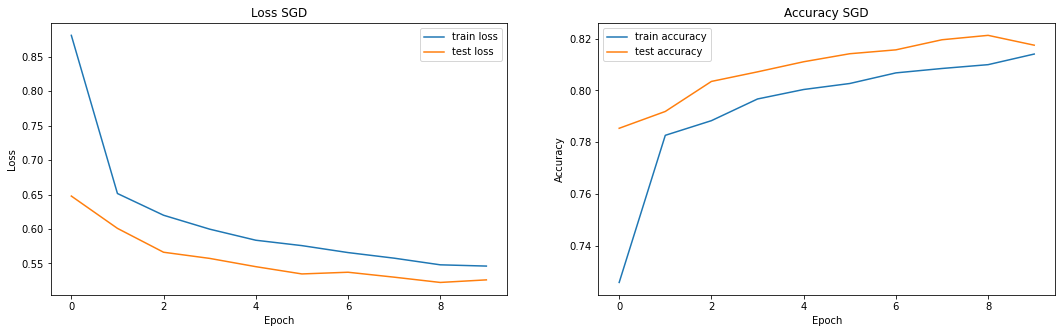

In [13]:
n_epochs = [*range(epochs)]
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(n_epochs, log['train_loss'])
plt.plot(n_epochs, log['test_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss SGD')
plt.legend(['train loss', 'test loss'])
plt.subplot(122)
plt.plot(n_epochs, log['train_acc'])
plt.plot(n_epochs, log['test_acc'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy SGD')
plt.legend(['train accuracy', 'test accuracy'])

# (A) : Frize All Weights Of Resnet 50 As Teacher

In [14]:
for param in model_res50.parameters():
    param.requires_grad = False

#  (A) : **Conclusion:**

*   The result of training pretrain resnet50 model based on frizing all previos layer except last fc layer on the test data is :
*   Accuracy: 81.8% , Avg Test loss : 0.526194 

# (B) : Load Resnet 18 Model Class As Student

In [15]:
model_res18 = torchvision.models.resnet18()

model_res18.fc = nn.Sequential(nn.Linear(512, 10))

trainable_param_number = sum(p.numel() for p in model_res18.parameters() if p.requires_grad)

print(f"Trainable Param Number Is : {trainable_param_number:,}")

Trainable Param Number Is : 11,181,642


# (B) : Define Hyper Parameters & Optimizer & Loss Function (Student)

In [16]:
def CELoss(y_hat, y_true):
    CE =  (-1 / batch_size) * torch.sum(y_true * torch.log(y_hat) + (1 - y_true) * torch.log(1 - y_hat))
    return CE

def distilled_loss(logit_T, logit_S, y, a=0.5, T=3):
    activation = nn.Softmax(dim = 1)
    loss =  ((1-a)*CELoss(activation(logit_S / T), y)) + (a*CELoss(activation(logit_S/T), activation(logit_T / T))) 
    return loss

device = "cuda" if torch.cuda.is_available() else "cpu"
model_res18 = model_res18.to(device)

criterion = distilled_loss

lr_sgd = 1e-3
epochs = 10
optimizer_sgd = torch.optim.SGD(model_res18.parameters(), lr=lr_sgd, momentum=0.9)

# (B) : Define Train & Test Loop For Student

In [17]:
def train_loop(dataloader, model_T, model_S, loss_fn, optimizer, log):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        
        logit_T = model_T(X.to(torch.float32).to(device))
        logit_S = model_S(X.to(torch.float32).to(device))
        
        loss = loss_fn(logit_T, logit_S, y.to(device), a=0.5, T=3)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (logit_S.argmax(1) == y.to(device).argmax(1)).type(torch.float).sum().item()
            
    train_loss /= num_batches
    train_acc /= size
    
    log['train_loss'].append(train_loss)
    log['train_acc'].append(train_acc)
    
    print(f"Train Result: \n Accuracy: {(100*train_acc):>0.1f}%, Avg Train loss: {train_loss:>8f} \n")

def test_loop(dataloader, model_T, model_S, loss_fn, log):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc, test_loss_min = 0, 0, np.Inf 
    
    with torch.no_grad():
        for X, y in dataloader:
            
            logit_T = model_T(X.to(torch.float32).to(device))
            logit_S = model_S(X.to(torch.float32).to(device))

            loss = loss_fn(logit_T, logit_S, y.to(device), a=0.5, T=3)

            test_loss += loss.item()
            test_acc += (logit_S.argmax(1) == y.to(device).argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    test_acc /= size
    
    if(log!=None):
        
        log['test_loss'].append(test_loss)
        log['test_acc'].append(test_acc)
        
        if(test_loss <= min(log['test_loss'])):
            torch.save(model_S.state_dict(), './model/best_res18_student_model.pt')
            print('Model Saved')    

    print(f"Test Result: \n Accuracy: {(100*test_acc):>0.1f}%, Avg Test loss: {test_loss:>8f} \n")       

# (B) : Training Process Of Resnet 18 As Student & Resnet 50 As Teacher

In [18]:
model_res50.eval()
if(Train_Res18_As_Student):
    
    log = {'train_loss':[], 'test_loss' : [], 'train_acc' : [], 'test_acc' : []}
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        model_res18.train()
        train_loop(train_loader, model_res50, model_res18, criterion, optimizer_sgd, log = log)
        model_res18.eval()
        test_loop(test_loader, model_res50, model_res18, criterion, log = log)
        
    print("Done!")
    
    with open('best_res18_student_result.pkl', 'wb') as f:
        pickle.dump(log, f)   
else:
    
    model_res18.load_state_dict(torch.load('./model/best_res18_student_model.pt'))  
    with open('best_res18_student_result.pkl', 'rb') as f:
        log = pickle.load(f)
    print('Model Loaded')
    model_res18.eval()
    test_loop(test_loader, model_res50, model_res18, criterion, log = None)

Epoch 1
-------------------------------
Train Result: 
 Accuracy: 34.7%, Avg Train loss: 2.842520 

Model Saved
Test Result: 
 Accuracy: 38.6%, Avg Test loss: 5.486439 

Epoch 2
-------------------------------
Train Result: 
 Accuracy: 50.3%, Avg Train loss: 2.546621 

Model Saved
Test Result: 
 Accuracy: 53.9%, Avg Test loss: 4.932785 

Epoch 3
-------------------------------
Train Result: 
 Accuracy: 58.6%, Avg Train loss: 2.400177 

Model Saved
Test Result: 
 Accuracy: 61.0%, Avg Test loss: 4.695757 

Epoch 4
-------------------------------
Train Result: 
 Accuracy: 64.2%, Avg Train loss: 2.306875 

Test Result: 
 Accuracy: 56.0%, Avg Test loss: 4.951292 

Epoch 5
-------------------------------
Train Result: 
 Accuracy: 68.8%, Avg Train loss: 2.236956 

Model Saved
Test Result: 
 Accuracy: 68.0%, Avg Test loss: 4.485880 

Epoch 6
-------------------------------
Train Result: 
 Accuracy: 72.1%, Avg Train loss: 2.187145 

Model Saved
Test Result: 
 Accuracy: 69.3%, Avg Test loss: 4.4

# (B) : Result Of Pretrained Resnet 50 As Teacher & Resnet 18 As Student

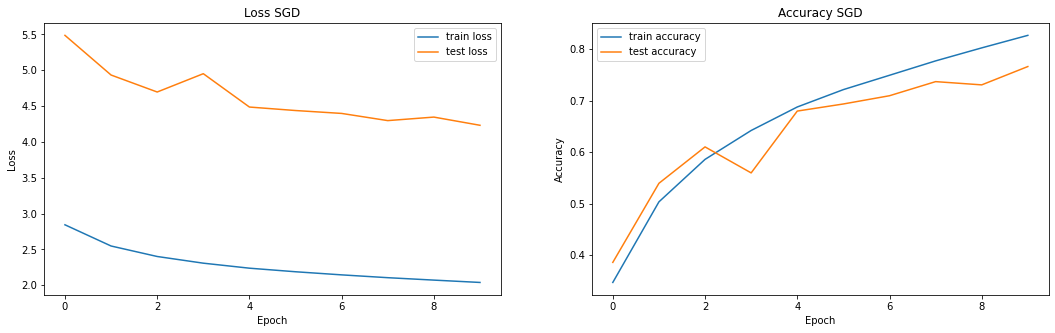

In [19]:
n_epochs = [*range(epochs)]
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(n_epochs, log['train_loss'])
plt.plot(n_epochs, log['test_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss SGD')
plt.legend(['train loss', 'test loss'])
plt.subplot(122)
plt.plot(n_epochs, log['train_acc'])
plt.plot(n_epochs, log['test_acc'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy SGD')
plt.legend(['train accuracy', 'test accuracy'])

#  (B) : **Conclusion:**

*   The result of training pretrain **resnet50** as teacher and **resnet18** as student on the test data is :
*   Accuracy: 76.6%, Avg Test loss: 4.231294 

# (C) : Load Resnet 18 Model Class From Scratch

In [21]:
model_resnet18_base = torchvision.models.resnet18()

model_resnet18_base.fc = nn.Sequential(nn.Linear(512, 10))

trainable_param_number = sum(p.numel() for p in model_resnet18_base.parameters() if p.requires_grad)

print(f"Trainable Param Number Is : {trainable_param_number:,}")

Trainable Param Number Is : 11,181,642


# (C) : Define Hyper Parameters & Optimizer & Loss Function

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_resnet18_base = model_resnet18_base.to(device)

criterion = nn.CrossEntropyLoss()

lr_sgd = 1e-3
epochs = 10
optimizer_sgd = torch.optim.SGD(model_resnet18_base.parameters(), lr=lr_sgd, momentum=0.9)

# (C) : Define Train & Test Loop For Train Resnet 18 From Scratch

In [24]:
def train_loop(dataloader, model, loss_fn, optimizer, log):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        
        pred = model(X.to(torch.float32).to(device))
        loss = loss_fn(pred, y.to(device))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (pred.argmax(1) == y.to(device).argmax(1)).type(torch.float).sum().item()
            
    train_loss /= num_batches
    train_acc /= size
    
    log['train_loss'].append(train_loss)
    log['train_acc'].append(train_acc)
    
    print(f"Train Result: \n Accuracy: {(100*train_acc):>0.1f}%, Avg Train loss: {train_loss:>8f} \n")

def test_loop(dataloader, model, loss_fn, log):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc, test_loss_min = 0, 0, np.Inf 
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(torch.float32).to(device))
            loss = loss_fn(pred, y.to(device))
            
            test_loss += loss.item()
            test_acc += (pred.argmax(1) == y.to(device).argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    test_acc /= size
    
    if(log!=None):
        
        log['test_loss'].append(test_loss)
        log['test_acc'].append(test_acc)
        
        if(test_loss <= min(log['test_loss'])):
            torch.save(model.state_dict(), './model/best_res18_fromscratch_model.pt')
            print('Model Saved')    

    print(f"Test Result: \n Accuracy: {(100*test_acc):>0.1f}%, Avg Test loss: {test_loss:>8f} \n")   

# (C) : Training Process Of Resnet 18 From Scratch

In [25]:
if(Train_Res18_FromScratch):
    
    log = {'train_loss':[], 'test_loss' : [], 'train_acc' : [], 'test_acc' : []}
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        model_resnet18_base.train()
        train_loop(train_loader, model_resnet18_base, criterion, optimizer_sgd, log = log)
        model_resnet18_base.eval()
        test_loop(test_loader, model_resnet18_base, criterion, log = log)
        
    print("Done!")
    
    with open('best_res18_fromscratch_result.pkl', 'wb') as f:
        pickle.dump(log, f)   
else:
    
    model_resnet18_base.load_state_dict(torch.load('./model/best_res18_fromscratch_model.pt'))  
    with open('best_res18_fromscratch_result.pkl', 'rb') as f:
        log = pickle.load(f)
    print('Model Loaded')
    model_resnet18_base.eval()
    test_loop(test_loader, model_resnet18_base, criterion, log = None)

Epoch 1
-------------------------------
Train Result: 
 Accuracy: 41.5%, Avg Train loss: 1.584016 

Model Saved
Test Result: 
 Accuracy: 46.8%, Avg Test loss: 1.507668 

Epoch 2
-------------------------------
Train Result: 
 Accuracy: 56.9%, Avg Train loss: 1.199532 

Model Saved
Test Result: 
 Accuracy: 53.0%, Avg Test loss: 1.340297 

Epoch 3
-------------------------------
Train Result: 
 Accuracy: 65.1%, Avg Train loss: 0.978126 

Model Saved
Test Result: 
 Accuracy: 65.6%, Avg Test loss: 0.983944 

Epoch 4
-------------------------------
Train Result: 
 Accuracy: 71.2%, Avg Train loss: 0.813689 

Model Saved
Test Result: 
 Accuracy: 71.2%, Avg Test loss: 0.809551 

Epoch 5
-------------------------------
Train Result: 
 Accuracy: 75.7%, Avg Train loss: 0.688862 

Test Result: 
 Accuracy: 69.8%, Avg Test loss: 0.869949 

Epoch 6
-------------------------------
Train Result: 
 Accuracy: 80.3%, Avg Train loss: 0.564862 

Model Saved
Test Result: 
 Accuracy: 73.9%, Avg Test loss: 0.7

# (C) : Result Of Resnet 18 Trained From Scratch

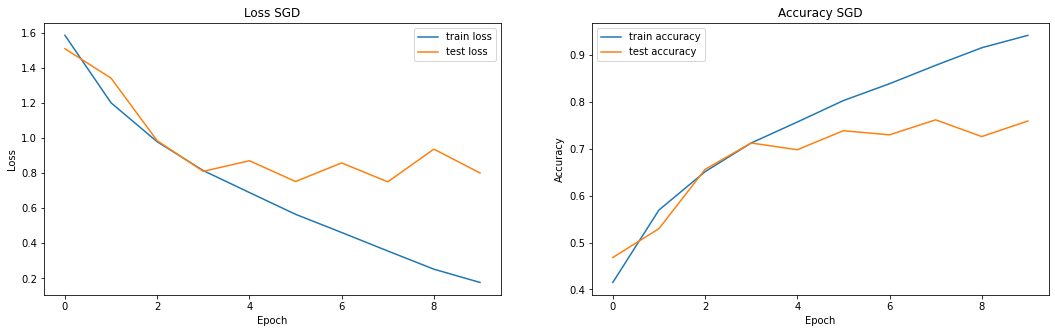

In [26]:
n_epochs = [*range(epochs)]
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(n_epochs, log['train_loss'])
plt.plot(n_epochs, log['test_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss SGD')
plt.legend(['train loss', 'test loss'])
plt.subplot(122)
plt.plot(n_epochs, log['train_acc'])
plt.plot(n_epochs, log['test_acc'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy SGD')
plt.legend(['train accuracy', 'test accuracy'])

#  (C) : **Conclusion:**

*   The result of training **resnet18** from scratch on the test data is :
*   Accuracy: 75.9%, Avg Test loss: 0.800326


*   The main point is that the accuracy is decreased when we train resnet18 from scratch because resnet18 is very small model but the complexity of the data is too much and the tiny model can not learn the complexity very well but when we use resnet50 as teacher of tiny model, it tries to learn from the hands of teacher to give us better result. Using teacher most of the time helps student to learn complex features and increas the accuracy of the student model.  


*   In our case the teacher increase the accuracy of the student model but not much because the accuracy of the teacher model is not very high because of only training of last layer of resnet50

# (D) : Load Resnet 50 Model Class For Finetuning

In [82]:
model_resnet50_base = torchvision.models.resnet50(pretrained=True)

model_resnet50_base.fc = nn.Sequential(nn.Linear(2048, 10))

trainable_param_number = sum(p.numel() for p in model_resnet50_base.parameters() if p.requires_grad)

print(f"Trainable Param Number Is : {trainable_param_number:,}")

Trainable Param Number Is : 23,528,522


# (D) : Define Hyper Parameters & Optimizer & Loss Function (Teacher)

In [83]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_resnet50_base = model_resnet50_base.to(device)

criterion = nn.CrossEntropyLoss()

lr_sgd = 1e-3
epochs = 10
optimizer_sgd = torch.optim.SGD(model_resnet50_base.parameters(), lr=lr_sgd, momentum=0.9)

# (D) : Define Train & Test Loop For Teacher

In [84]:
def train_loop(dataloader, model, loss_fn, optimizer, log):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        
        pred = model(X.to(torch.float32).to(device))
        loss = loss_fn(pred, y.to(device))
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (pred.argmax(1) == y.to(device).argmax(1)).type(torch.float).sum().item()
            
    train_loss /= num_batches
    train_acc /= size
    
    log['train_loss'].append(train_loss)
    log['train_acc'].append(train_acc)
    
    print(f"Train Result: \n Accuracy: {(100*train_acc):>0.1f}%, Avg Train loss: {train_loss:>8f} \n")

def test_loop(dataloader, model, loss_fn, log):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc, test_loss_min = 0, 0, np.Inf 
    
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(torch.float32).to(device))
            loss = loss_fn(pred, y.to(device))
            
            test_loss += loss.item()
            test_acc += (pred.argmax(1) == y.to(device).argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    test_acc /= size
    
    if(log!=None):
        
        log['test_loss'].append(test_loss)
        log['test_acc'].append(test_acc)
        
        if(test_loss <= min(log['test_loss'])):
            torch.save(model.state_dict(), './model/best_res50Finetuning_teacher_model.pt')
            print('Model Saved')    

    print(f"Test Result: \n Accuracy: {(100*test_acc):>0.1f}%, Avg Test loss: {test_loss:>8f} \n")   

# (D) : Training Process Of Resnet 50 Fro Finetuning As Teacher

In [70]:
if(Train_Res50_Finetuning_As_Teacher):
    
    log = {'train_loss':[], 'test_loss' : [], 'train_acc' : [], 'test_acc' : []}
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        model_resnet50_base.train()
        train_loop(train_loader, model_resnet50_base, criterion, optimizer_sgd, log = log)
        model_resnet50_base.eval()
        test_loop(test_loader, model_resnet50_base, criterion, log = log)
        
    print("Done!")
    
    with open('best_res50Finetuning_teacher_result.pkl', 'wb') as f:
        pickle.dump(log, f)   
else:
    
    model_resnet50_base.load_state_dict(torch.load('./model/best_res50Finetuning_teacher_model.pt'))  
    with open('best_res50Finetuning_teacher_result.pkl', 'rb') as f:
        log = pickle.load(f)
    print('Model Loaded')
    model_resnet50_base.eval()
    test_loop(test_loader, model_resnet50_base, criterion, log = None)

Epoch 1
-------------------------------
Train Result: 
 Accuracy: 89.6%, Avg Train loss: 0.323531 

Model Saved
Test Result: 
 Accuracy: 95.3%, Avg Test loss: 0.141930 

Epoch 2
-------------------------------
Train Result: 
 Accuracy: 96.7%, Avg Train loss: 0.098916 

Model Saved
Test Result: 
 Accuracy: 95.9%, Avg Test loss: 0.125213 

Epoch 3
-------------------------------
Train Result: 
 Accuracy: 98.5%, Avg Train loss: 0.048750 

Model Saved
Test Result: 
 Accuracy: 96.1%, Avg Test loss: 0.119453 

Epoch 4
-------------------------------
Train Result: 
 Accuracy: 99.2%, Avg Train loss: 0.027494 

Test Result: 
 Accuracy: 96.3%, Avg Test loss: 0.123233 

Epoch 5
-------------------------------
Train Result: 
 Accuracy: 99.4%, Avg Train loss: 0.019038 

Test Result: 
 Accuracy: 96.1%, Avg Test loss: 0.138311 

Epoch 6
-------------------------------
Train Result: 
 Accuracy: 99.7%, Avg Train loss: 0.013372 

Test Result: 
 Accuracy: 96.3%, Avg Test loss: 0.133794 

Epoch 7
--------

# (D) : Result Of Resnet 50 From Scratch As Teacher 

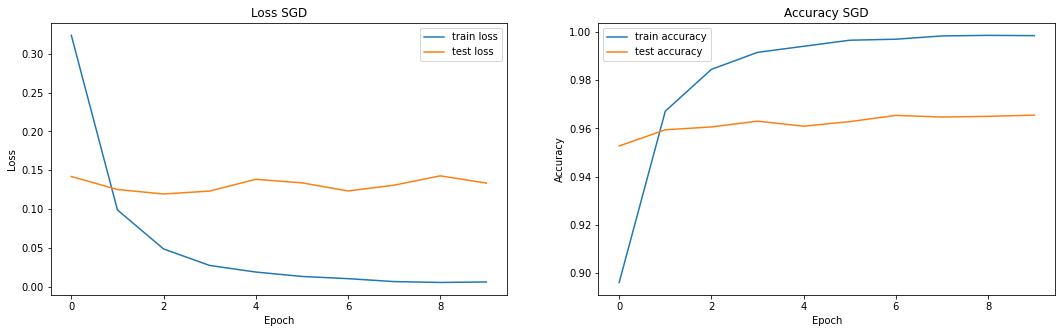

In [71]:
n_epochs = [*range(epochs)]
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(n_epochs, log['train_loss'])
plt.plot(n_epochs, log['test_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss SGD')
plt.legend(['train loss', 'test loss'])
plt.subplot(122)
plt.plot(n_epochs, log['train_acc'])
plt.plot(n_epochs, log['test_acc'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy SGD')
plt.legend(['train accuracy', 'test accuracy'])

# (D) : Frize All Weights Of Resnet 50 Finetuned As Teacher

In [72]:
for param in model_resnet50_base.parameters():
    param.requires_grad = False

# (D) : Load Res 18 Model Class As Student For Res 50 Finetuned

In [73]:
model_res18_fromscratch = torchvision.models.resnet18()

model_res18_fromscratch.fc = nn.Sequential(nn.Linear(512, 10))

trainable_param_number = sum(p.numel() for p in model_res18_fromscratch.parameters() if p.requires_grad)

print(f"Trainable Param Number Is : {trainable_param_number:,}")

Trainable Param Number Is : 11,181,642


# (D) : Define Hyper Parameters & Optimizer & Loss Function (Student)

In [74]:
def CELoss(y_hat, y_true):
    CE =  (-1 / batch_size) * torch.sum(y_true * torch.log(y_hat) + (1 - y_true) * torch.log(1 - y_hat))
    return CE

def distilled_loss(logit_T, logit_S, y, a=0.5, T=3):
    activation = nn.Softmax(dim = 1)
    loss =  ((1-a)*CELoss(activation(logit_S / T), y)) + (a*CELoss(activation(logit_S/T), activation(logit_T / T))) 
    return loss

device = "cuda" if torch.cuda.is_available() else "cpu"
model_res18_fromscratch = model_res18_fromscratch.to(device)

criterion = distilled_loss

lr_sgd = 1e-3
epochs = 10
optimizer_sgd = torch.optim.SGD(model_res18_fromscratch.parameters(), lr=lr_sgd, momentum=0.9)

# (D) : Define Train & Test Loop For Student

In [75]:
def train_loop(dataloader, model_T, model_S, loss_fn, optimizer, log):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        
        logit_T = model_T(X.to(torch.float32).to(device))
        logit_S = model_S(X.to(torch.float32).to(device))
        
        loss = loss_fn(logit_T, logit_S, y.to(device), a=0.5, T=3)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_acc += (logit_S.argmax(1) == y.to(device).argmax(1)).type(torch.float).sum().item()
            
    train_loss /= num_batches
    train_acc /= size
    
    log['train_loss'].append(train_loss)
    log['train_acc'].append(train_acc)
    
    print(f"Train Result: \n Accuracy: {(100*train_acc):>0.1f}%, Avg Train loss: {train_loss:>8f} \n")

def test_loop(dataloader, model_T, model_S, loss_fn, log):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_acc, test_loss_min = 0, 0, np.Inf 
    
    with torch.no_grad():
        for X, y in dataloader:
            
            logit_T = model_T(X.to(torch.float32).to(device))
            logit_S = model_S(X.to(torch.float32).to(device))

            loss = loss_fn(logit_T, logit_S, y.to(device), a=0.5, T=3)

            test_loss += loss.item()
            test_acc += (logit_S.argmax(1) == y.to(device).argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    test_acc /= size
    
    if(log!=None):
        
        log['test_loss'].append(test_loss)
        log['test_acc'].append(test_acc)
        
        if(test_loss <= min(log['test_loss'])):
            torch.save(model_S.state_dict(), './model/best_res18FromScratch_student_model.pt')
            print('Model Saved')    

    print(f"Test Result: \n Accuracy: {(100*test_acc):>0.1f}%, Avg Test loss: {test_loss:>8f} \n")  

# (D) : Training Res 18 As (S) & Res 50 (Finetuned As (T))

In [76]:
model_resnet50_base.eval()
if(Train_Res18_Finetuning_As_Student):
    
    log = {'train_loss':[], 'test_loss' : [], 'train_acc' : [], 'test_acc' : []}
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        model_res18_fromscratch.train()
        train_loop(train_loader, model_resnet50_base, model_res18_fromscratch, criterion, optimizer_sgd, log = log)
        model_res18_fromscratch.eval()
        test_loop(test_loader, model_resnet50_base, model_res18_fromscratch, criterion, log = log)
        
    print("Done!")
    
    with open('best_res18FromScratch_student_result.pkl', 'wb') as f:
        pickle.dump(log, f)   
else:
    
    model_res18_fromscratch.load_state_dict(torch.load('./model/best_res18FromScratch_student_model.pt'))  
    with open('best_res18FromScratch_student_result.pkl', 'rb') as f:
        log = pickle.load(f)
    print('Model Loaded')
    model_res18_fromscratch.eval()
    test_loop(test_loader, model_resnet50_base, model_res18_fromscratch, criterion, log = None)

Epoch 1
-------------------------------
Train Result: 
 Accuracy: 34.8%, Avg Train loss: 2.677658 

Model Saved
Test Result: 
 Accuracy: 29.3%, Avg Test loss: 6.251761 

Epoch 2
-------------------------------
Train Result: 
 Accuracy: 51.8%, Avg Train loss: 2.188262 

Model Saved
Test Result: 
 Accuracy: 51.0%, Avg Test loss: 4.596658 

Epoch 3
-------------------------------
Train Result: 
 Accuracy: 60.7%, Avg Train loss: 1.895602 

Model Saved
Test Result: 
 Accuracy: 63.9%, Avg Test loss: 3.588944 

Epoch 4
-------------------------------
Train Result: 
 Accuracy: 67.2%, Avg Train loss: 1.684449 

Test Result: 
 Accuracy: 60.0%, Avg Test loss: 4.008672 

Epoch 5
-------------------------------
Train Result: 
 Accuracy: 72.1%, Avg Train loss: 1.514752 

Model Saved
Test Result: 
 Accuracy: 69.0%, Avg Test loss: 3.288669 

Epoch 6
-------------------------------
Train Result: 
 Accuracy: 76.5%, Avg Train loss: 1.372378 

Test Result: 
 Accuracy: 70.2%, Avg Test loss: 3.297036 

Epoc

# (D) : Result Of Res 50 From Scratch As Teacher & Res 18 As Student

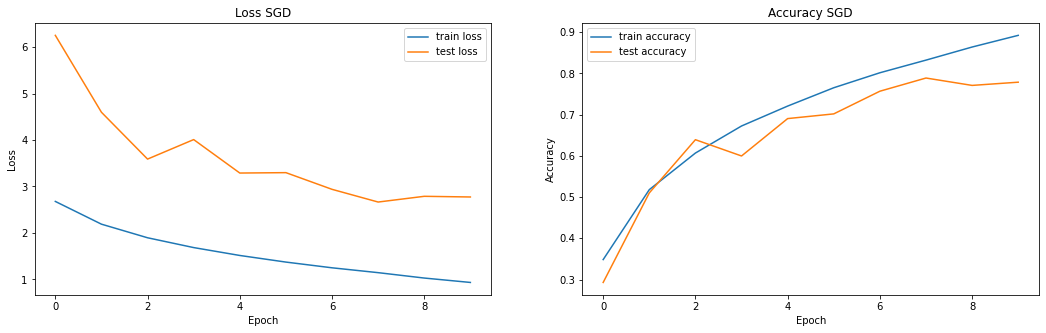

In [77]:
n_epochs = [*range(epochs)]
plt.figure(figsize=(18,5))
plt.subplot(121)
plt.plot(n_epochs, log['train_loss'])
plt.plot(n_epochs, log['test_loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Loss SGD')
plt.legend(['train loss', 'test loss'])
plt.subplot(122)
plt.plot(n_epochs, log['train_acc'])
plt.plot(n_epochs, log['test_acc'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title('Accuracy SGD')
plt.legend(['train accuracy', 'test accuracy'])

#  (D) : **Conclusion:**

*   The result of finetuned **resnet50** as a teacher on the test data is :
*   Accuracy: 96.5% , Avg Test loss: 0.133449


*   The result of **resnet18** base on finetuned teacher(**resnet50**) on the test data is :
*   Accuracy: 77.9% , Avg Test loss: 2.773405  


*   When we finetune the whole teacher model(**resnet50**), all the weights are updated and get a better result but in the previous model only the weights of the last layer are updated and the other weights are based on imagenet model.


*   The training time for finetuning the whole teacher model(**resnet50**) is increased beacause the backpropagation should be done on the whole of weights not only the last layer.


*   When the accuracy of the teacher model(**resnet50**) increases, the accuracy of the student(**resnet18**) will be improved.